In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils

In [15]:
os.chdir('/home/walml/repos/agnfinder')

In [77]:

# save_dir = 'results/emulated_sampling/real'
# save_dir = '/media/walml/beta/agnfinder_results/euclid_med_real_unc_fixed_z'
save_dir = 'results/emulated_sampling/30k_burnin'

all_galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
assert all_galaxy_locs




In [79]:
galaxy_locs = [x for x in all_galaxy_locs if 'galaxy_55_' in x]

In [80]:
galaxy_locs

['results/emulated_sampling/30k_burnin/galaxy_55_performance_0.h5',
 'results/emulated_sampling/30k_burnin/galaxy_55_performance_1.h5']

In [94]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 
       10205.12640526])



In [107]:
galaxy_locs = all_galaxy_locs

In [308]:
# open one galaxy for params
with h5py.File(galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']


galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
#         print(f['is_accepted'][...].mean())
            if f['is_accepted'][...].mean() < 0.6:
                print(f['is_accepted'])
            else:
                galaxy = {
#                     'free_param_names': f['free_param_names'],
                    'samples': np.squeeze(f['samples'][::100]),
                    'name': galaxy_loc.split('_')[-3],
                    'chain': galaxy_loc.split('_')[-1].rstrip('.h5'),
                    'true_observations': np.squeeze(f['true_observations'][...]),
                    'true_params': np.squeeze(f['true_params'][...]),
#                     'redshift': f['fixed_params'][...],
                    'uncertainty': f['uncertainty'][...]
                }
                samples = np.squeeze(f['samples'][...])
                galaxy['median_spread'] = median_spread(samples)
                galaxy['percentile_spreads'] = percentile_spreads(samples)
                galaxies.append(galaxy)
                
    except OSError:
        pass
    
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:overflow encountered in subtract


In [309]:

def percentile_spreads(samples):
    return np.percentile(samples, 75, axis=0) - np.percentile(samples, 25, axis=0)

In [310]:
pcs = np.abs(np.array([x['percentile_spreads'] for x in galaxies]))
valid_pcs = pcs[np.all(pcs < 1., axis=1)]

In [311]:
len(pcs), len(valid_pcs)

(645, 641)

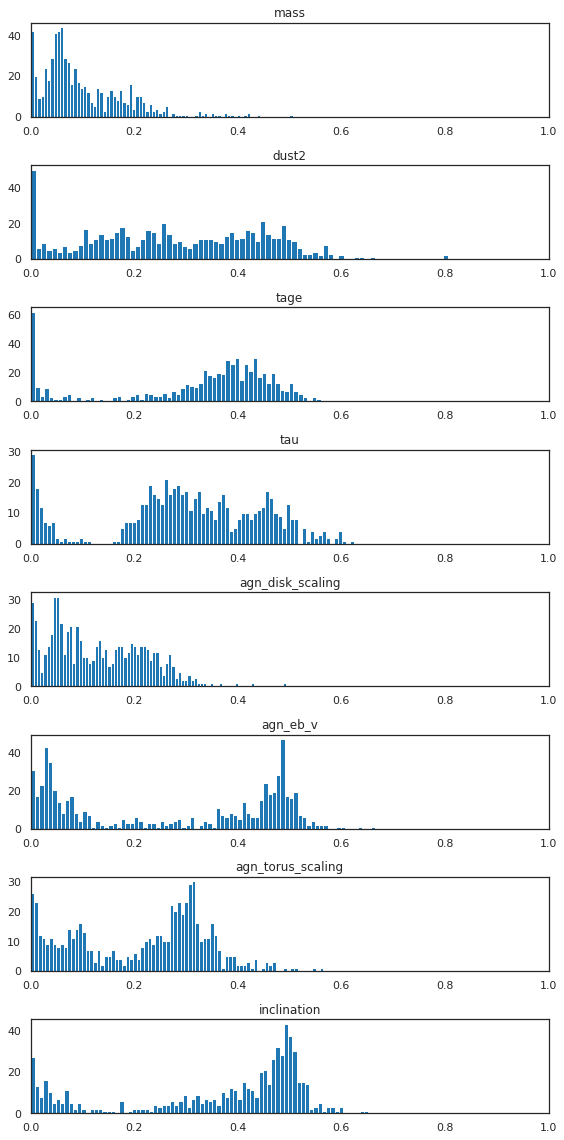

In [312]:
fig, axes = plt.subplots(nrows=8, figsize=(8, 16))
for param_n in range(8):
    ax = axes[param_n]
    ax.hist(valid_pcs[:, param_n], bins=80)
    ax.set_title(params[param_n])
    ax.set_xlim([0., 1.])
fig.tight_layout()

In [313]:
valid_pcs.shape

(641, 8)

In [321]:
limits = np.percentile(valid_pcs, q=12, axis=0)
limits

array([0.02320089, 0.05288815, 0.02667919, 0.0457426 , 0.02810684,
       0.02691569, 0.02951607, 0.04369169])

In [322]:
# np.mean(valid_pcs < limits, axis|=1) > 0.

In [323]:
np.mean(np.sum(valid_pcs < limits, axis=1) > 1.)

0.1497659906396256

In [327]:
galaxy['percentile_spreads']

array([0.0493433 , 0.37414738, 0.22692494, 0.59334746, 0.16470675,
       0.28636116, 0.0295805 , 0.29811174])

In [331]:
for galaxy in galaxies:
    galaxy['good_spread'] = np.sum(galaxy['percentile_spreads'] < limits) < 2.

In [332]:
np.mean([g['good_spread'] for g in galaxies])

0.8511627906976744

In [338]:
data = galaxies.copy()
# for g in data:
#     del g['samples']
df = pd.DataFrame(data=data)
df.head()

name chain                                  true_observations  \
0   55     0  [1.7887363e-08, 4.7851117e-08, 8.9958846e-08, ...   
1  372     1  [7.217091e-07, 2.5887762e-06, 8.627765e-06, 2....   
2  237     0  [2.046453e-09, 3.3498722e-09, 9.647908e-09, 1....   
3  430     0  [1.6054187e-07, 2.573843e-07, 5.2558914e-07, 6...   
4   85     0  [1.0194627e-12, 2.2286973e-12, 6.430697e-12, 1...   

                                         true_params  \
0  [0.27136666, 0.2877757, 0.3593122, 0.76999146,...   
1  [0.7430308, 0.5811921, 0.6477517, 0.8259002, 0...   
2  [0.6653551, 0.5966939, 0.13013098, 0.4129713, ...   
3  [0.93419147, 0.47568694, 0.083009094, 0.994878...   
4  [0.089015655, 0.14560707, 0.36026633, 0.188068...   

                                         uncertainty  median_spread  \
0  [8.5016943e-10, 1.4355335e-09, 2.6987652e-09, ...       0.790778   
1  [2.1651273e-08, 7.766328e-08, 2.5883296e-07, 6...       0.623031   
2  [3.0696795e-10, 2.3467991e-10, 3.3819966e-10, ...       0.887359   
3  [4.8162563e-09, 7.721529e-09, 1.5767673e-08, 1...       0.648731   
4  [1.5291941e-13, 3.343046e-13, 9.646046e-13, 1....       0.977764   

                                  percentile_spreads  good_spread  
0  [0.049343302845954895, 0.37414737790822983, 0....         True  
1  [0.12723471224308014, 0.22625161707401276, 0.4...         True  
2  [0.06645466387271881, 0.21111387759447098, 0.4...         True  
3  [0.05123147368431091, 0.10930494219064713, 0.0...         True  
4  [0.05717467702925205, 0.44571325182914734, 0.4...         True

In [345]:
df.query('chain == "0"')['good_spread'].mean(), df.query('chain == "1"')['good_spread'].mean()

(0.8373493975903614, 0.865814696485623)

In [351]:
bad_first_chains = df.query('good_spread == False').query('chain == "0"')
bad_first_chains.head()
bad_chains = bad_first_chains['name'].values

In [353]:
bad_first_chains_df = df[df['name'].isin(bad_chains)]
rerun = bad_first_chains_df.groupby('name').agg({'good_spread': np.any}).reset_index()
rerun['good_spread'].mean()

0.35185185185185186

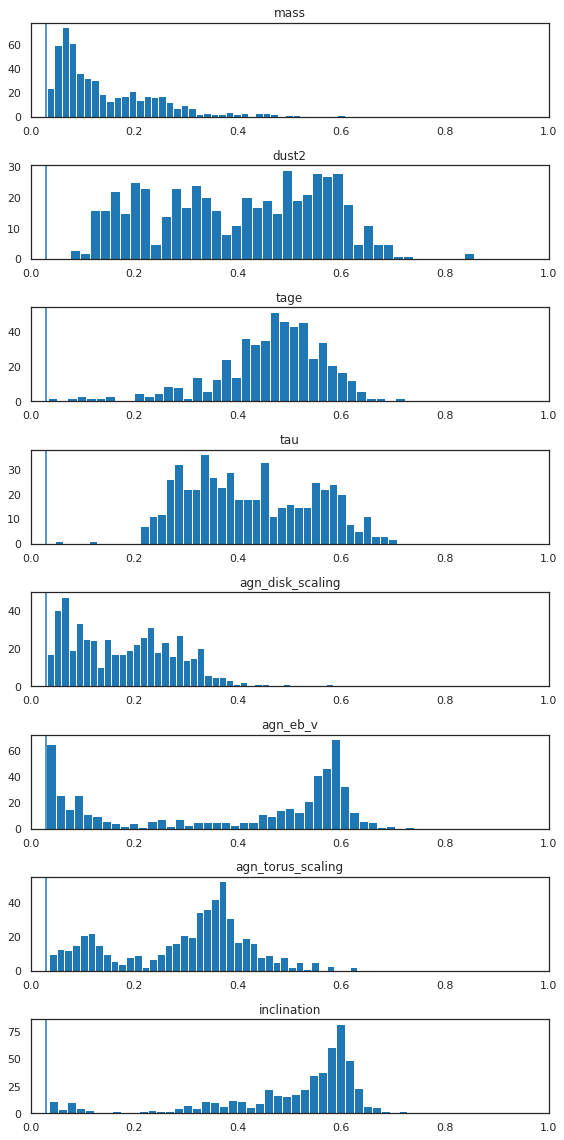

In [209]:
min_spread = 0.03
allowed_pcs = np.all(min_spread < valid_pcs, axis=1)
selected_pcs = valid_pcs[allowed_pcs]
fig, axes = plt.subplots(nrows=8, figsize=(8, 16))
for param_n in range(8):
    ax = axes[param_n]
    ax.hist(selected_pcs[:, param_n], bins=40)
    ax.set_title(params[param_n])
    ax.axvline(min_spread)
    ax.set_xlim([0., 1.])
fig.tight_layout()

In [148]:
median_spreads = np.array([g['median_spread'] for g in galaxies])
median_spreads_no_inf = median_spreads[~np.isinf(median_spreads)]
(median_spreads_no_inf > 1).sum()
median_spreads_valid = median_spreads[median_spreads < 1]

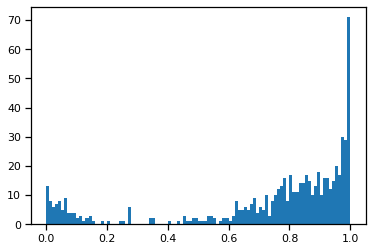

In [157]:
counts, bins, _ = plt.hist(median_spreads_valid, bins=100)

In [158]:
bins

array([0.        , 0.0099975 , 0.019995  , 0.0299925 , 0.03999   ,
       0.04998751, 0.05998501, 0.06998251, 0.07998001, 0.08997751,
       0.09997501, 0.10997251, 0.11997002, 0.12996751, 0.13996501,
       0.14996251, 0.15996002, 0.16995752, 0.17995502, 0.18995252,
       0.19995002, 0.20994753, 0.21994503, 0.22994253, 0.23994003,
       0.24993753, 0.25993502, 0.26993254, 0.27993003, 0.28992754,
       0.29992503, 0.30992255, 0.31992003, 0.32991755, 0.33991504,
       0.34991255, 0.35991004, 0.36990756, 0.37990505, 0.38990256,
       0.39990005, 0.40989757, 0.41989505, 0.42989257, 0.43989006,
       0.44988757, 0.45988506, 0.46988258, 0.47988006, 0.48987758,
       0.49987507, 0.50987256, 0.51987004, 0.5298676 , 0.5398651 ,
       0.54986256, 0.55986005, 0.5698576 , 0.5798551 , 0.5898526 ,
       0.59985006, 0.6098476 , 0.6198451 , 0.6298426 , 0.63984007,
       0.6498376 , 0.6598351 , 0.6698326 , 0.6798301 , 0.6898276 ,
       0.6998251 , 0.7098226 , 0.7198201 , 0.7298176 , 0.73981

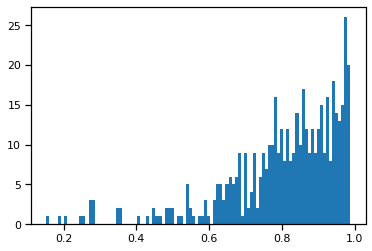

In [162]:
_ = plt.hist(median_spreads_valid[(median_spreads_valid < 0.988) & (median_spreads_valid > 0.15)], bins=100)

In [163]:
from agnfinder.tf_sampling import parameter_recovery

1005 galaxies loaded [00:00, 6204.46 galaxies loaded/s]
233 galaxies loaded [00:01, 124.61 galaxies loaded/s] /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:114: RuntimeWarning:invalid value encountered in greater
1005 galaxies loaded [00:08, 124.74 galaxies loaded/s]
 /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:45: RuntimeWarning:invalid value encountered in true_divide


(<Figure size 864x864 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3a4e36d50>,
       dtype=object))

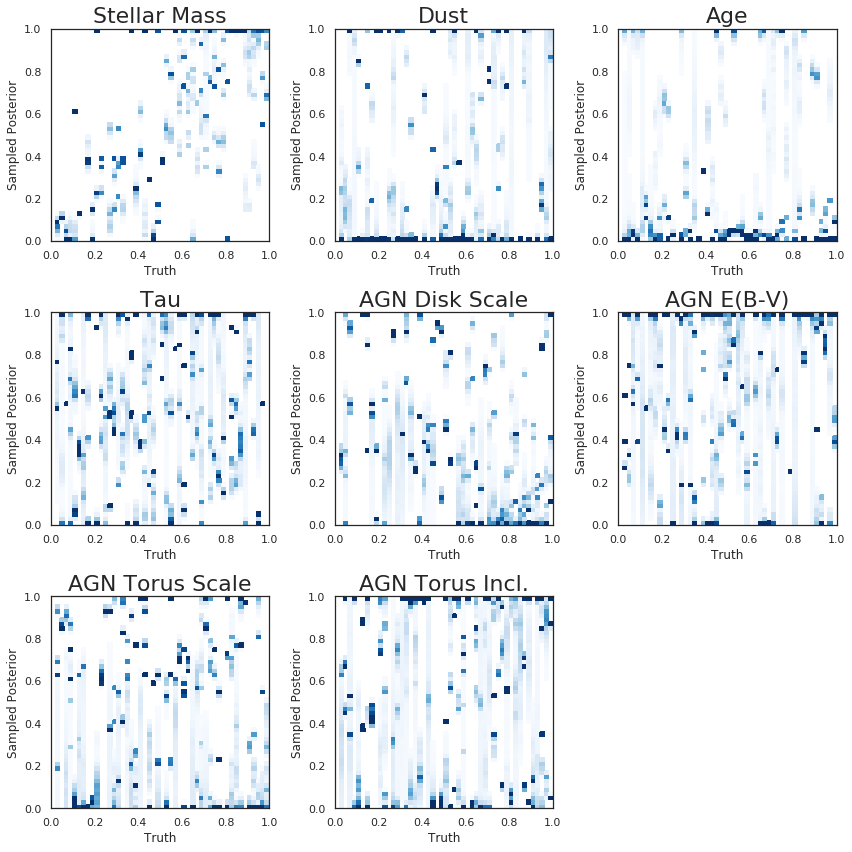

In [305]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

1005 galaxies loaded [00:00, 5185.85 galaxies loaded/s]
239 galaxies loaded [00:02, 105.73 galaxies loaded/s] /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:114: RuntimeWarning:invalid value encountered in greater
1005 galaxies loaded [00:08, 116.44 galaxies loaded/s]
 /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:45: RuntimeWarning:invalid value encountered in true_divide


(<Figure size 864x864 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3afe7ca50>,
       dtype=object))

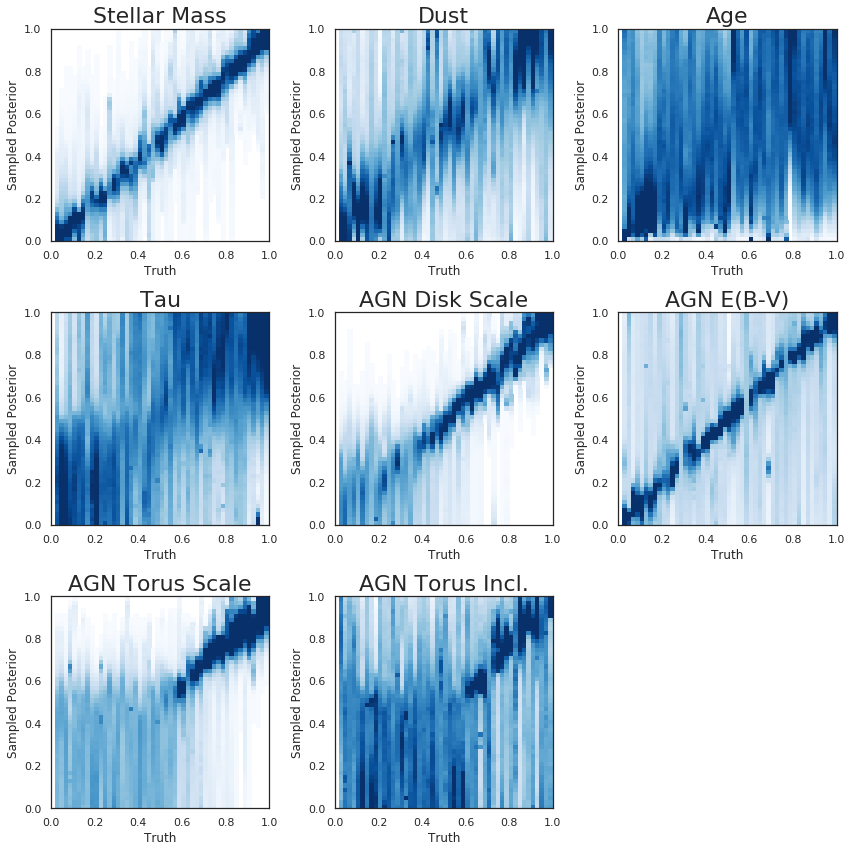

In [270]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

1005 galaxies loaded [00:00, 6015.82 galaxies loaded/s]
243 galaxies loaded [00:02, 109.32 galaxies loaded/s] /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:114: RuntimeWarning:invalid value encountered in greater
1005 galaxies loaded [00:08, 117.93 galaxies loaded/s]
 /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:45: RuntimeWarning:invalid value encountered in true_divide


(<Figure size 864x864 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3b1d6fbd0>,
       dtype=object))

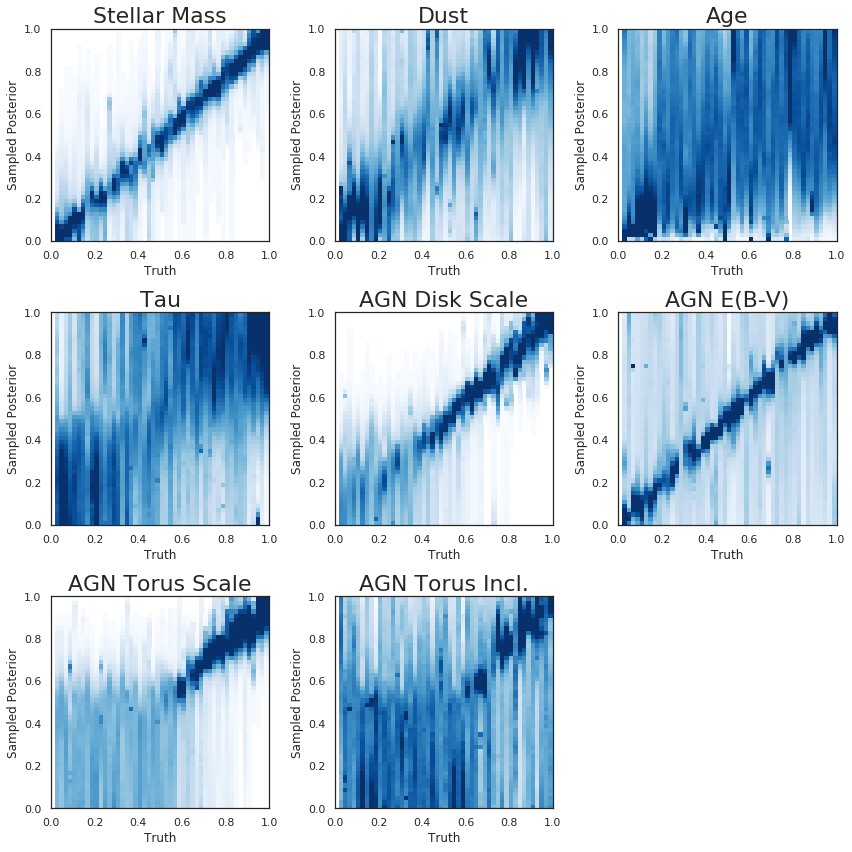

In [257]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

1005 galaxies loaded [00:00, 5928.65 galaxies loaded/s]
235 galaxies loaded [00:02, 115.04 galaxies loaded/s] /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:114: RuntimeWarning:invalid value encountered in greater
1005 galaxies loaded [00:08, 114.55 galaxies loaded/s]
 /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:45: RuntimeWarning:invalid value encountered in true_divide


(<Figure size 864x864 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3b39d9fd0>,
       dtype=object))

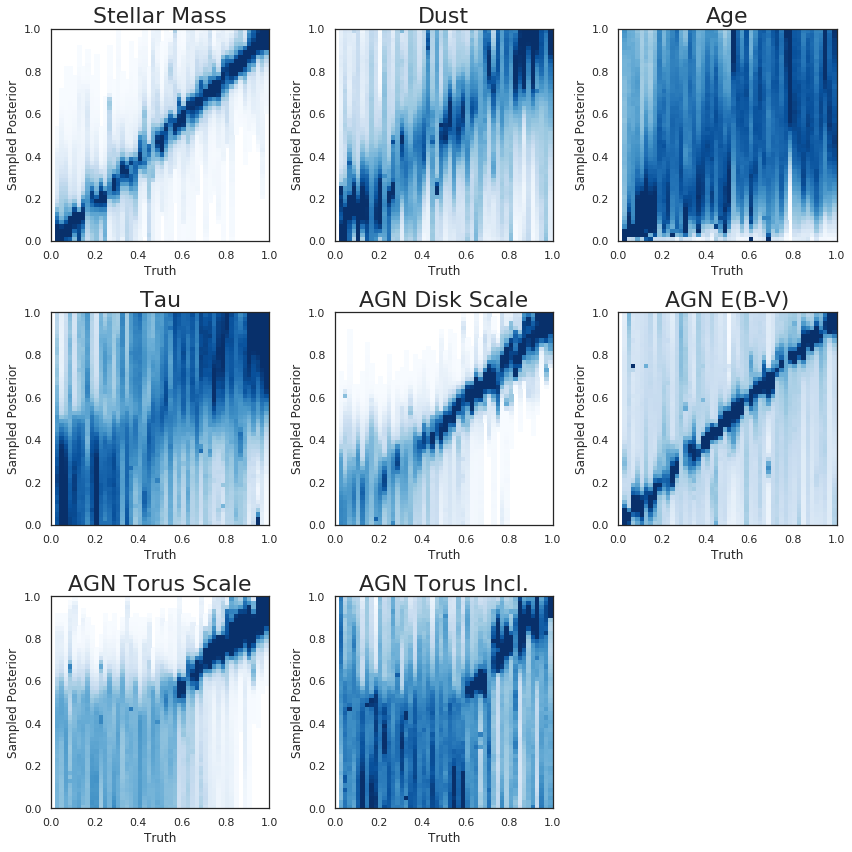

In [249]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

1005 galaxies loaded [00:00, 5411.89 galaxies loaded/s]
243 galaxies loaded [00:02, 98.26 galaxies loaded/s]  /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:114: RuntimeWarning:invalid value encountered in greater
1005 galaxies loaded [00:09, 109.00 galaxies loaded/s]
 /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:45: RuntimeWarning:invalid value encountered in true_divide


(<Figure size 864x864 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3ac0139d0>,
       dtype=object))

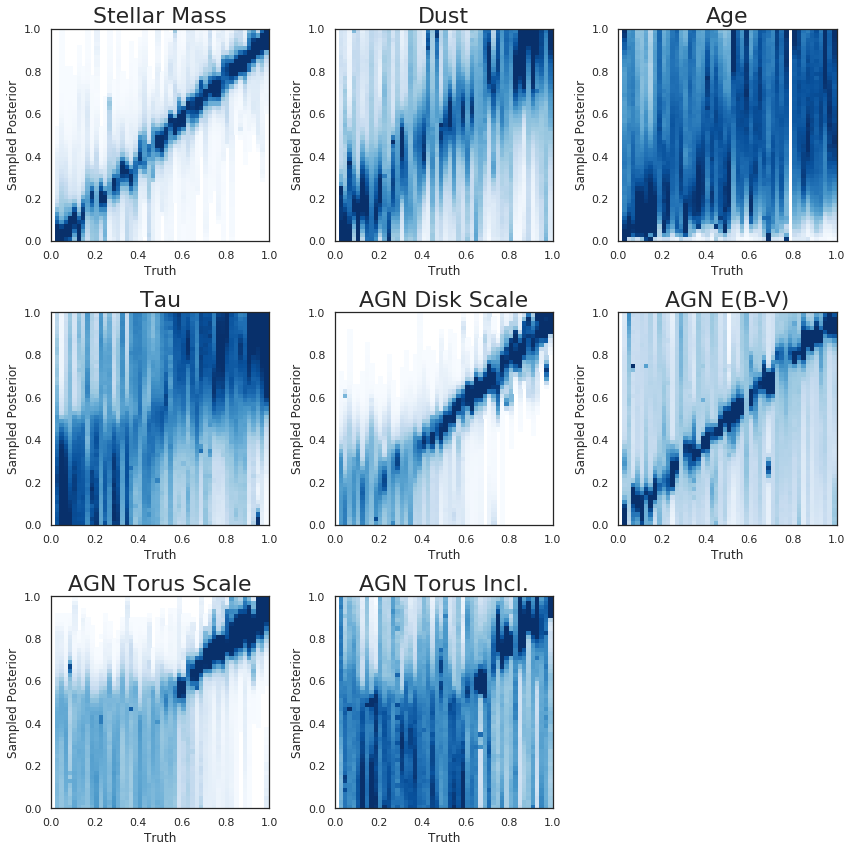

In [206]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

1005 galaxies loaded [00:00, 6686.05 galaxies loaded/s]
1005 galaxies loaded [00:08, 119.78 galaxies loaded/s]


(<Figure size 864x864 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3aded0910>,
       dtype=object))

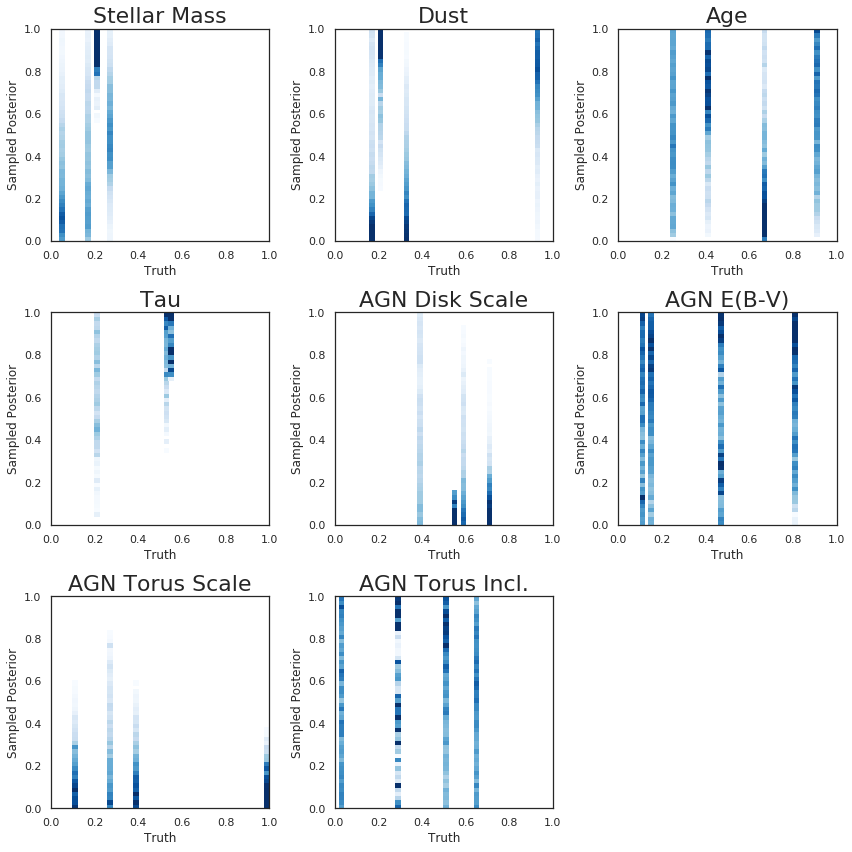

In [199]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

1005 galaxies loaded [00:00, 6540.69 galaxies loaded/s]
226 galaxies loaded [00:00, 528.68 galaxies loaded/s] /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:113: RuntimeWarning:invalid value encountered in greater
1005 galaxies loaded [00:01, 666.75 galaxies loaded/s]
 /home/walml/repos/agnfinder/agnfinder/tf_sampling/parameter_recovery.py:45: RuntimeWarning:invalid value encountered in true_divide


(<Figure size 864x864 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3ad0cc110>,
       dtype=object))

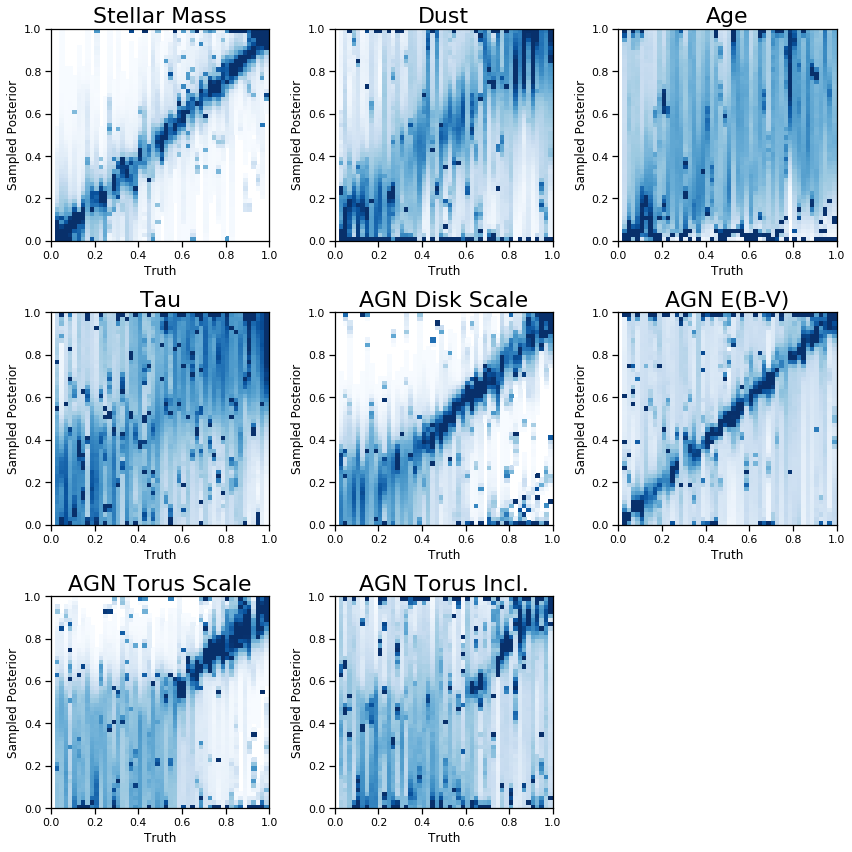

In [164]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

In [135]:
np.max(median_spreads), np.argmax(median_spreads), median_spreads[79]

(inf, 150, 0.86526513)

In [144]:
inf_galaxy = galaxies[np.argmax(median_spreads)]
inf_galaxy['samples'].min(), inf_galaxy['samples'].max()
inf_galaxy['samples'][0]
# plt.hist(inf_galaxy['samples'][0:3].flatten())

array([-3.0282234e+38,  1.5448006e+37,  3.0473493e+38,  9.9038185e+37,
       -1.0462162e+38,  2.0346831e+38,  1.2482912e+38, -2.2488730e+38],
      dtype=float32)

In [145]:
inf_galaxy

{'samples': array([[-3.0282234e+38,  1.5448006e+37,  3.0473493e+38, ...,
          2.0346831e+38,  1.2482912e+38, -2.2488730e+38],
        [-3.1171192e+38,  7.0401303e+37,  2.8759954e+38, ...,
         -2.4737441e+37,  1.3176412e+38, -2.4147628e+38],
        [-2.3595813e+38,  4.0938244e+37,  2.9052649e+38, ...,
         -1.3212558e+38,  3.8229797e+36, -1.5839365e+38],
        ...,
        [-1.1819077e+37, -1.4575299e+38,  5.6558427e+37, ...,
          9.0407208e+37, -3.2629748e+38,  7.7381738e+37],
        [-1.3039958e+38, -4.1755696e+37,  5.2342333e+37, ...,
         -4.2086371e+36, -2.4366106e+38,  2.7789994e+37],
        [-1.5492382e+38, -1.2798806e+38,  5.1478388e+37, ...,
         -2.7190608e+37, -1.9945215e+38,  5.0013456e+37]], dtype=float32),
 'name': '201',
 'chain': '0',
 'true_observations': array([1.1015098e-10, 1.1908188e-10, 1.5228102e-10, 1.6526419e-10,
        2.0539985e-10, 1.9899250e-10, 2.2964111e-10, 2.2192717e-10],
       dtype=float32),
 'true_params': array([0.08

In [ ]:
# corner.corner(inf_galaxy['samples'])
plt.loglog(wavelengths, inf_galaxy['true_observations'], marker='+', linestyle='')

In [ ]:
# broken_galaxy = galaxies[~np.isinf(median_spreads)][np.argmax(median_spreads)]
# broken_galaxy['median_spread']

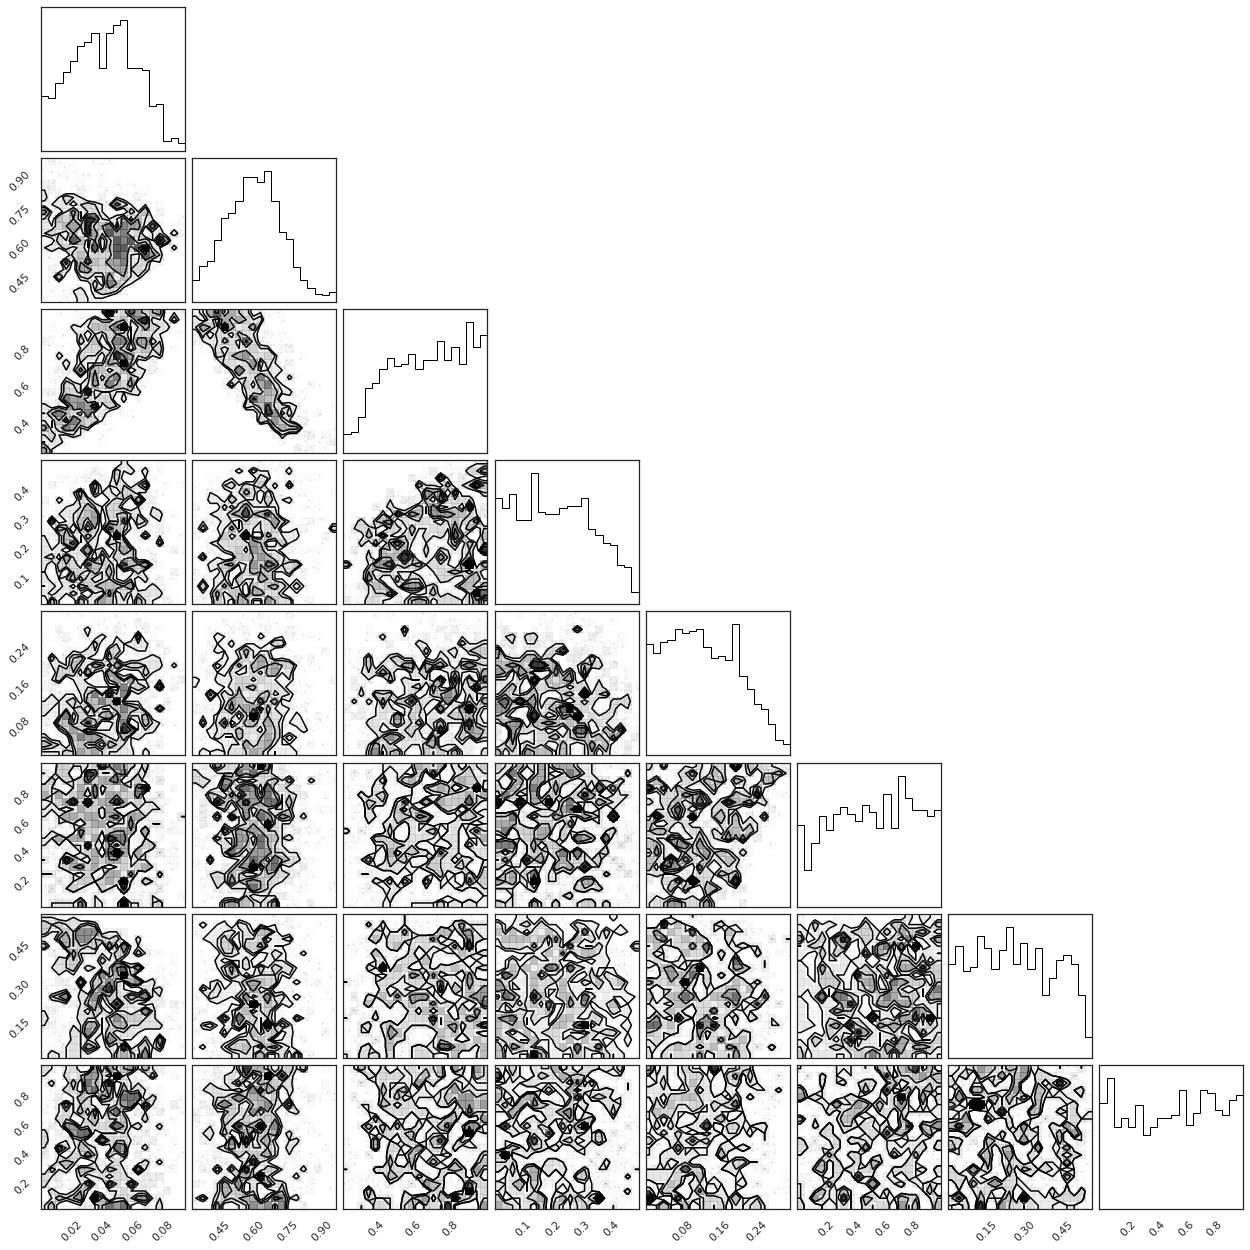

In [166]:
_ = corner.corner(broken_galaxy['samples'])

(array([ 45.,  12.,  60., 211.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.       ,  0.2554239,  0.5108478,  0.7662717,  1.0216956,
         1.2771195,  1.5325434,  1.7879673,  2.0433912,  2.2988153,
         2.554239 ,  2.8096628,  3.0650868,  3.3205109,  3.5759346,
         3.8313584,  4.0867825,  4.3422065,  4.5976305,  4.853054 ,
         5.108478 ,  5.363902 ,  5.6193256,  5.8747497,  6.1301737,
         6.3855977,  6.6410217,  6.8964453,  7.1518693,  7.4072933,
         7.662717 ,  7.918141 ,  8.173565 ,  8.428988 ,  8.684413 ,
         8.9398365,  9.195261 ,  9.450685 ,  9.706108 ,  9.961533 ,
        10.216956 ], dtype=float32),
 <a list of 40 Patch objects>)

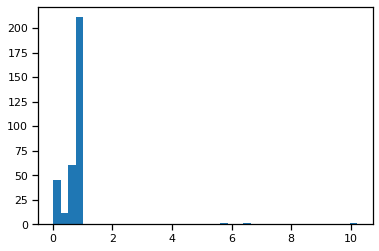

In [119]:
plt.hist(median_spreads, bins=40)

In [171]:
def median_spread(samples):
    return np.median(np.max(samples, axis=0) - np.min(samples, axis=0))

def percentile_spreads(samples):
    return np.percentile(samples, 75, axis=0) - np.percentile(samples, 25, axis=0)

In [104]:
median_spread(galaxy['samples'])

0.062548175

In [82]:
galaxy_loc

'results/emulated_sampling/30k_burnin/galaxy_55_performance_1.h5'

In [103]:
galaxy = galaxies[1]

In [97]:
galaxy['uncertainty'] / galaxy['true_observations']

array([0.04752905, 0.03      , 0.03      , 0.03      , 0.03      ,
       0.03      , 0.03      , 0.03      ], dtype=float32)

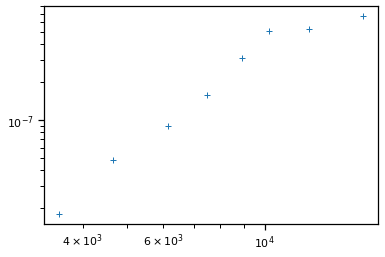

In [95]:
plt.loglog(wavelengths, galaxy['true_observations'], marker='+', linestyle='')

In [91]:
galaxy['name'], galaxy['chain']

('55', '0')

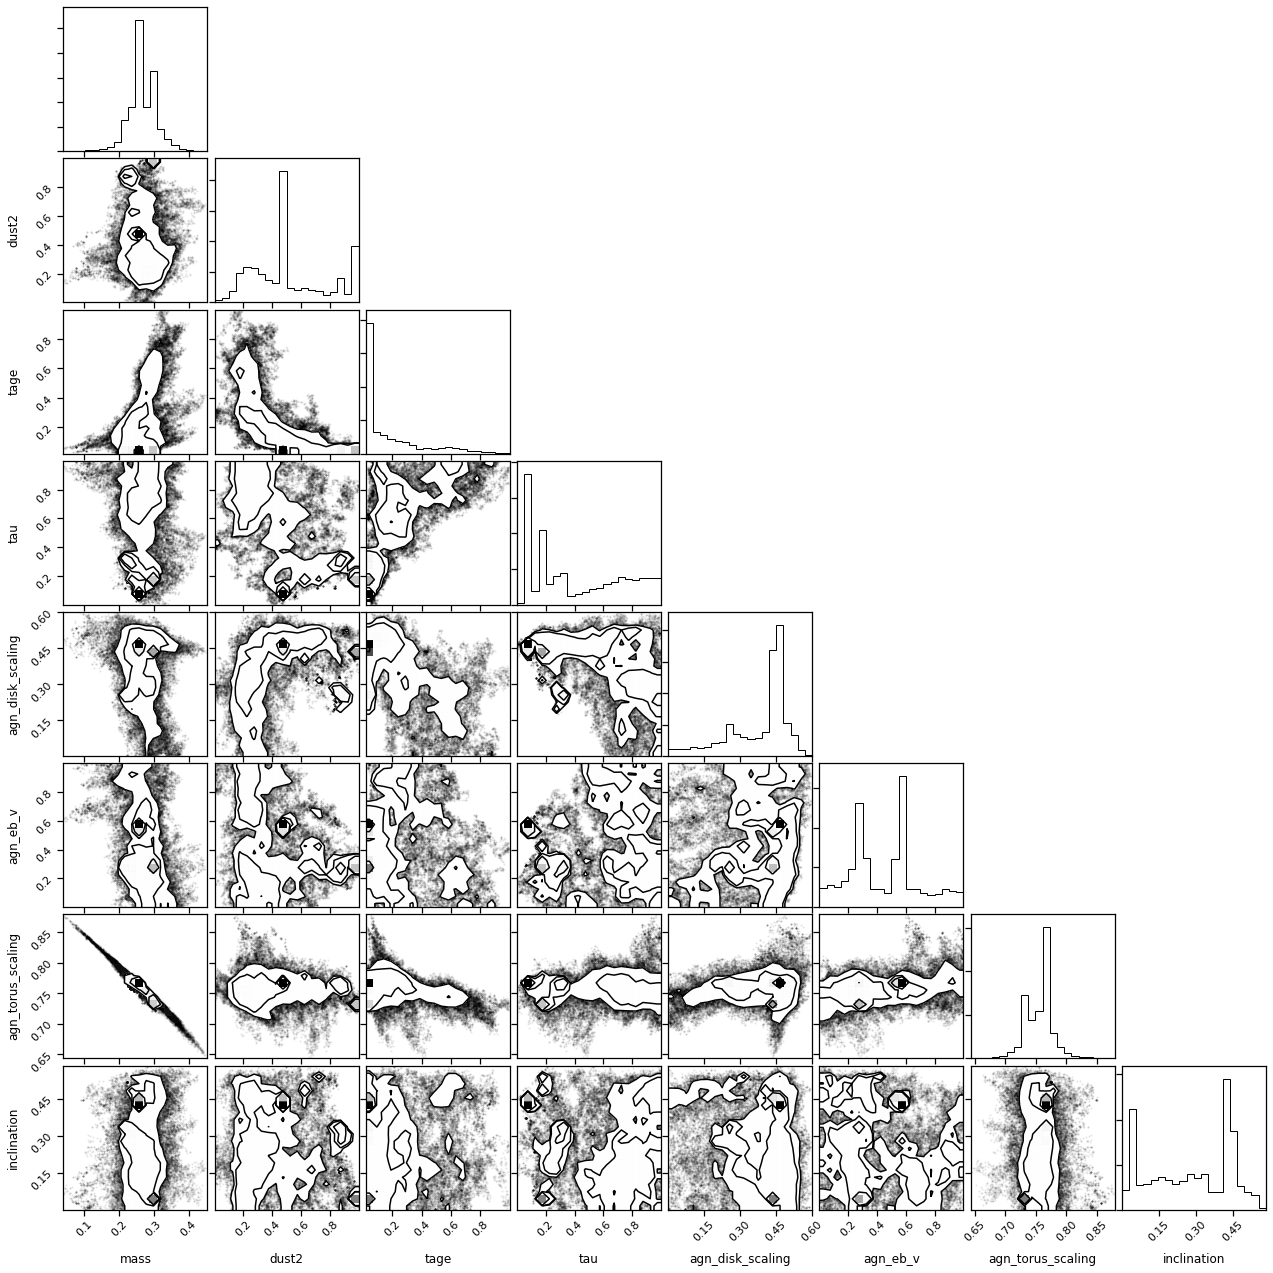

In [92]:
_ = corner.corner(galaxy['samples'], labels=params)

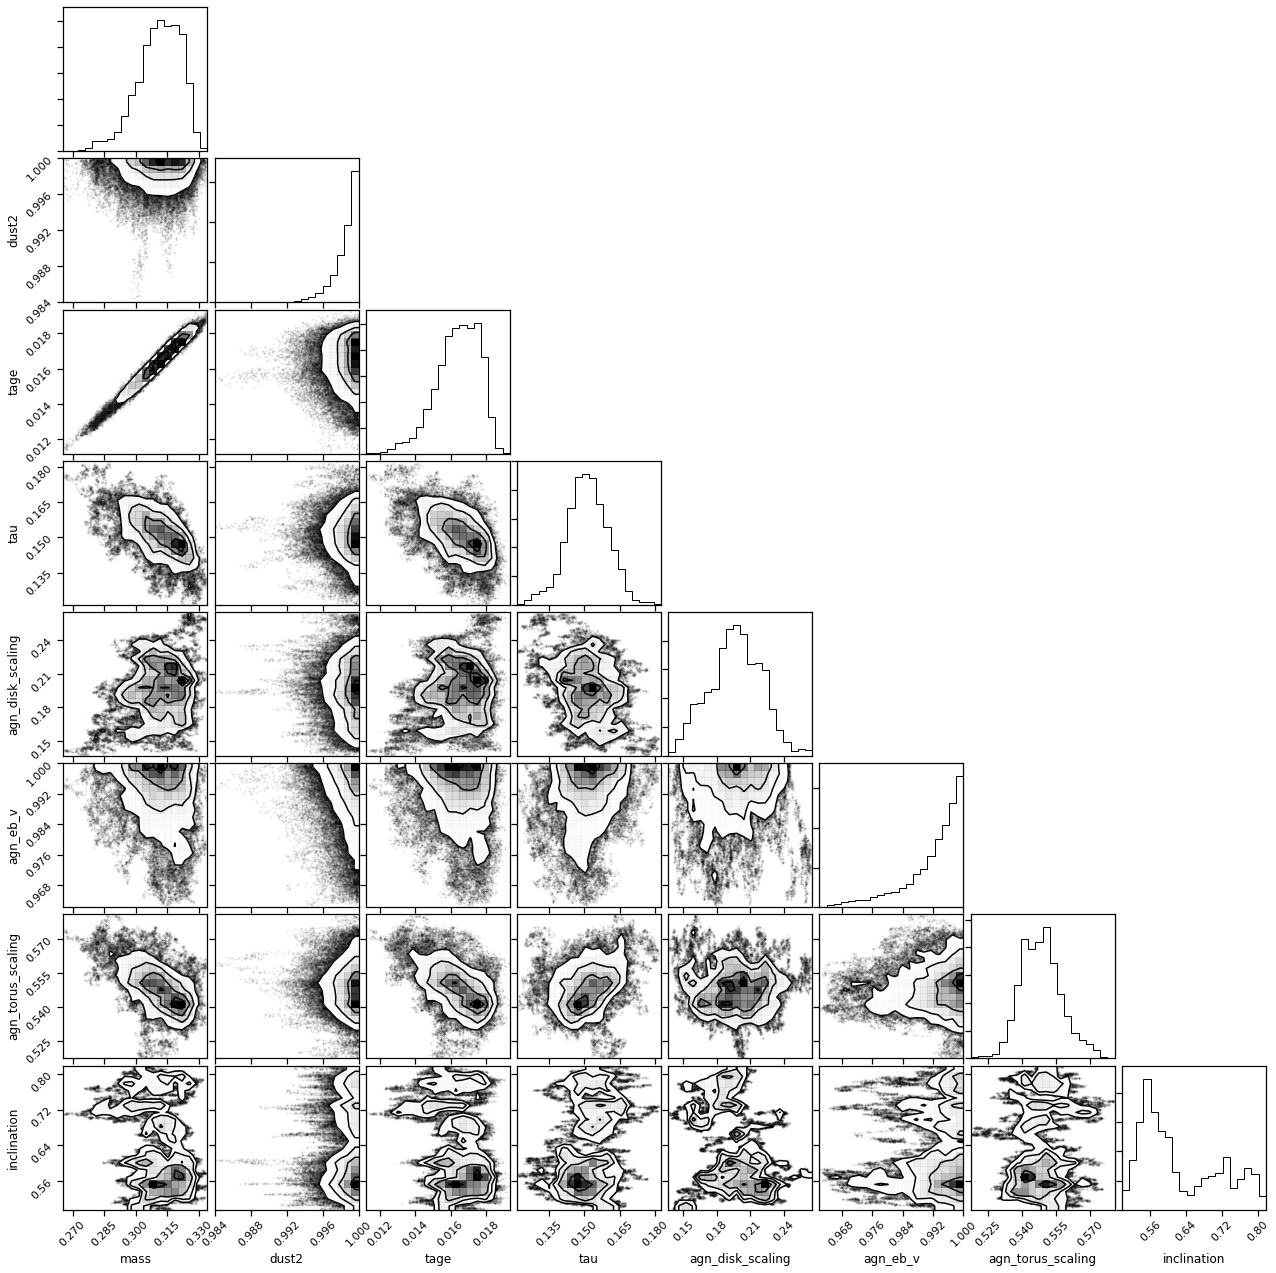

In [87]:
_ = corner.corner(galaxy['samples'], labels=params)

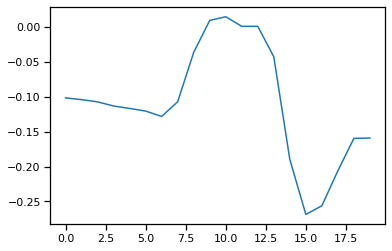

In [45]:
geweke = az.geweke(galaxy['samples'])
geweke.shape
plt.plot(geweke[:, 1])

In [46]:
samples = galaxy['samples']
true_params = galaxy['true_params']

In [47]:
ds = az.convert_to_dataset(np.expand_dims(samples, axis=0), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity

In [48]:
ds

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 80000, x_dim_0: 8)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 79994 79995 79996 79997 79998 79999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    x        (chain, draw, x_dim_0) float32 0.25097808 0.4899337 ... 0.41716456
Attributes:
    created_at:  2020-02-10T15:06:53.574637

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argume

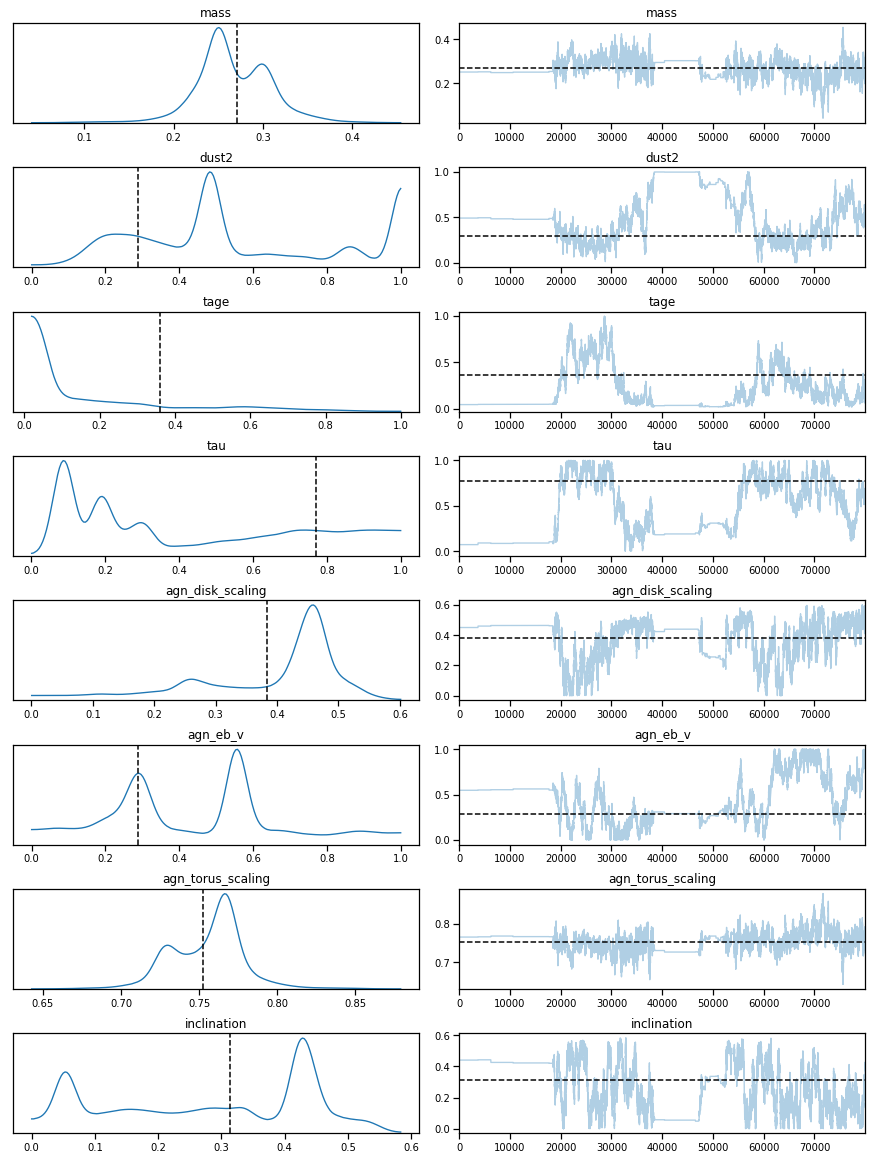

In [49]:
axes = az.plot_trace(ds)  
for param_n in range(len(true_params)):
    axes[param_n][0].set_title(params[param_n])
    axes[param_n][1].set_title(params[param_n])
    axes[param_n][0].axvline(true_params[param_n], linestyle='--', color='k')
    axes[param_n][1].axhline(true_params[param_n], linestyle='--', color='k')

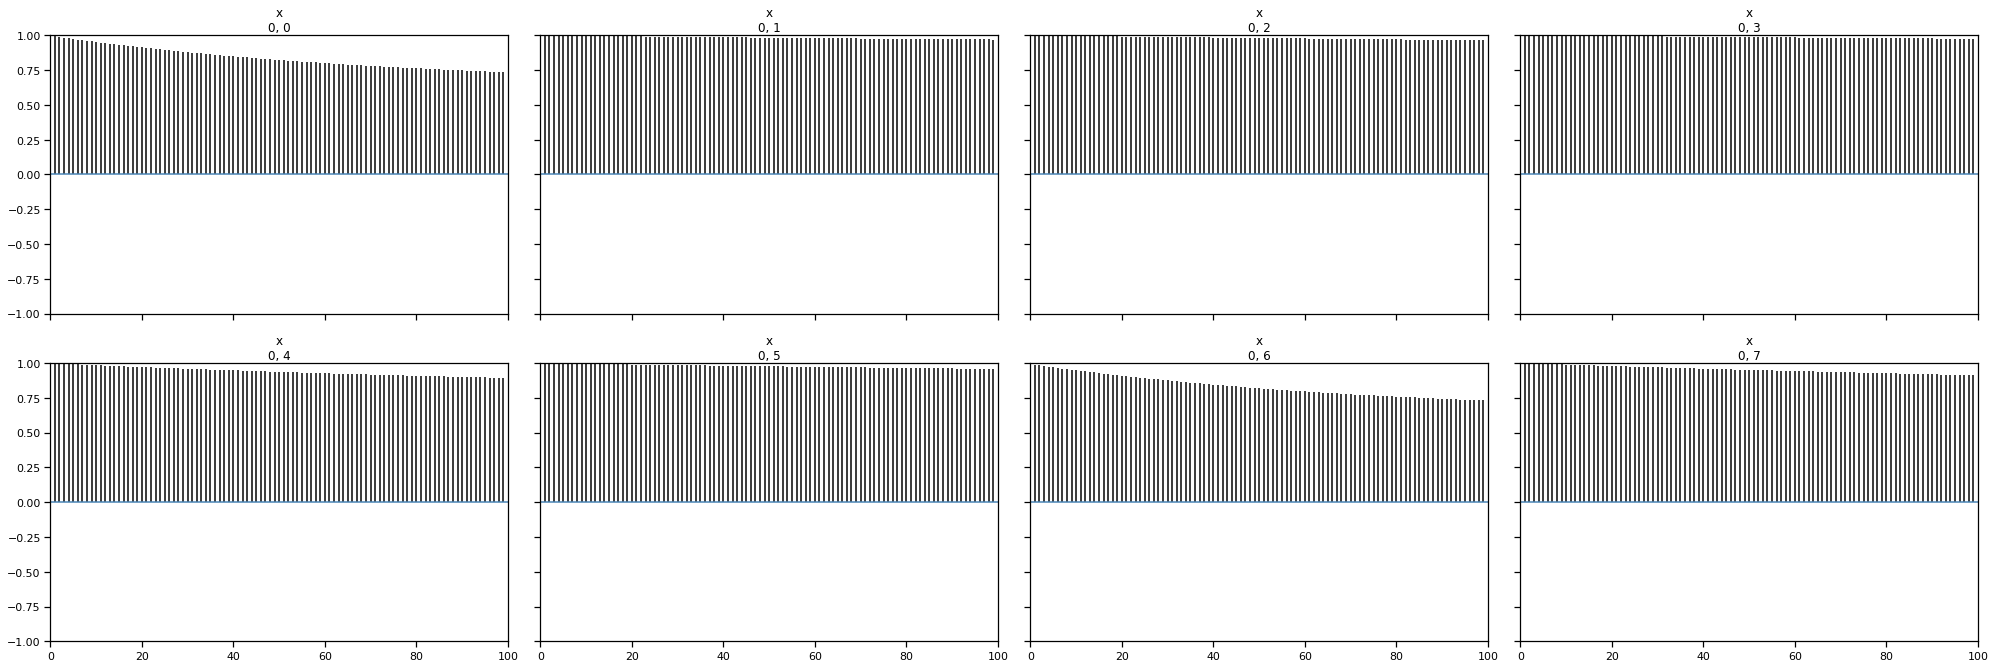

In [50]:
_ = az.plot_autocorr(ds)

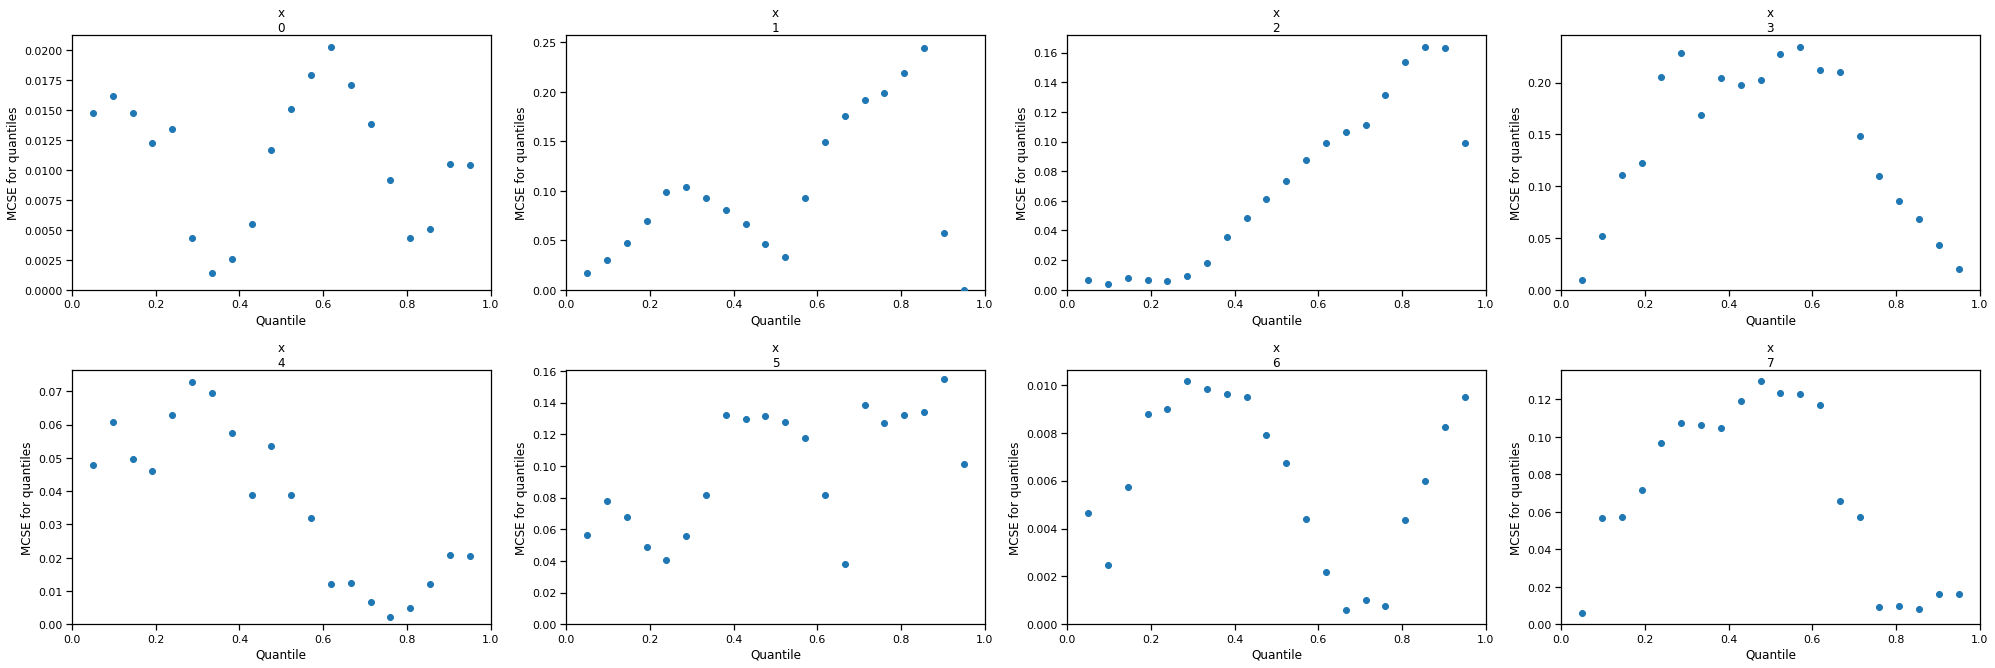

In [51]:
_ = az.plot_mcse(ds)

In [52]:
ds

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 80000, x_dim_0: 8)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 79994 79995 79996 79997 79998 79999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    x        (chain, draw, x_dim_0) float32 0.25097808 0.4899337 ... 0.41716456
Attributes:
    created_at:  2020-02-10T15:06:53.574637

In [53]:
az.ess(ds)

<xarray.Dataset>
Dimensions:  (x_dim_0: 8)
Coordinates:
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    x        (x_dim_0) float64 19.94 9.284 8.505 7.174 21.85 8.77 20.56 5.604

In [54]:
# Plot local ESS. This plot, together with the quantile ESS plot, is recommended to check that there are enough samples for all the explored regions of parameter space.
_ = az.plot_ess(ds, kind="local")

KeyboardInterrupt: 

In [ ]:
_ = az.plot_ess(ds, kind="quantile")

In [ ]:
# Plot ESS evolution as the number of samples increase. When the model is converging properly, both lines in this plot should be roughly linear.
_ = az.plot_ess(ds, kind="evolution")